## Basics

Because curli fibers grow out from the cell membrane, and we are interested in the phase before a biofilm is formed by the fibers we will base the model on the simulation of one bacteria cell and the fibers that grow out of it.

Curli fibril formation has two important microscopic reaction steps. Nucleation, and elongation. Nucleation is when a csgB monomer attaches to the cell membrane to start a curli fibril. Elongation is when a csgA monomer attaches to a fibril end.

CsgA and csgB monomers are produced by bacteria cells, and released through the membrane, which could pose the question of a concentration gradient with higher concentrations near the membrane, however the diffusion speed of these monomers is so monumentally fast micrometers/s that the micrometer distances between cells do not matter. This makes the highly useful approximation of constant (in space) concentrations possible. It is however not constant in time, as monomers are created and absorbed, as well as degrading.

In essence, the model needs to include a simulation of monomer concentration changes, fibril nucleations, and fibril elongations.

First of all, there need to be some systems imported for the code to work. The programs randomCompexAddition, numericaldiffusion and curliutil are utiliary programs which will make this program easier to write.

In [19]:
import numpy as np
import randomComplexAddition
from numericaldiffusion import inhibitedCsgAC
import curliutil
import cmath
from scipy.constants import N_A
import copy

Next up is a model of the individual curli fibrils, which will be modelled by a python class keeping track of angularity relative to the bacterial cell, position of the fibril end, and number of monomers added to the fibril. There is also a function which compares fibril positions that will be useful later.

In [20]:
class CurliFibril(object):
    SIGMA = 3.47 #degrees
    KPLUS = 21000 #/mol s
    UNITL = 4e-9

    def __init__(self, index):
        self.pos = 0
        self.alpha = np.random.normal(0,self.SIGMA*np.pi/180)
        self.size = 1
        self.index = index
    
    def __lt__(self, other):
        if self.pos < other.pos:
            return True
        return False


After this model of the fibril there needs to be a model of the fibril growing over the passage of time.

In [21]:
class UniformFibrilFormation(object): 
    def __init__(self, dist, xsteps, deltat,  inhibitors = [], cBacteria=1e12, initial_concentration = None, fibril0 = None):
        self.dist = dist
        self.CSGBRATE = 1.3e-13*N_A/cBacteria #n / bac / s
        self.xsteps = xsteps
        self.deltat = deltat
        self.deltax = dist / xsteps
        self.cBacteria = cBacteria
        if initial_concentration == None:
            self.C = inhibitedCsgAC(dist, xsteps, deltat, cBacteria, how = 'uniform',c0=None, inhibitors=inhibitors)
        else:
            self.C = initial_concentration
        
        if fibril0 == None:
            self.endpointSets = [curliutil.ListDict() for _ in range(xsteps)]
            self.massProfile = np.zeros(xsteps)
            self.index = 0
            self.totalMass = 0
        else:
            self.endpointSets = copy.deepcopy(fibril0.endpointSets)
            self.massProfile = copy.deepcopy(fibril0.massProfile)
            self.index = copy.deepcopy(fibril0.index)
            self.totalMass = copy.deepcopy(fibril0.totalMass)
            self.C.c = copy.deepcopy(fibril0.C.c)
    
    def getTime(self):
        return self.C.time
    def getMass(self):
        return self.totalMass
    def getFibrils(self):
        fibrils = []
        for i in self.endpointSets:
            fibrils += i.items
        return fibrils
    def getConcentration(self):
        return self.C.c
    def getMassProfile(self):
        return self.massProfile
    
    def elongate(self,fibril):
        pos0 = fibril.pos
        fibril.alpha += np.random.normal(0,fibril.SIGMA*np.pi/180)
        fibril.size += 1
        fibril.pos += fibril.UNITL*np.cos(fibril.alpha)
        diff = fibril.pos % self.deltax
        fi = lambda i : int(np.floor(i))
        self.totalMass += 1
        if fi(fibril.pos / self.deltax) != fi(pos0 / self.deltax):
            self.massProfile[fi(pos0 / self.deltax)] += (abs(fibril.pos -pos0)-diff) / abs(fibril.pos -pos0)
            self.massProfile[fi(fibril.pos / self.deltax)] += diff / abs(fibril.pos -pos0)
            return
        else:
            self.massProfile[fi(pos0 / self.deltax)] += 1
        return
        
    def timeStep(self):
        for x in np.random.choice([*range(self.xsteps)], size=self.xsteps, replace=False):
            if len(self.endpointSets[x]) > 0:
                kwrates = {'kplus':CurliFibril.KPLUS}
                for inh in self.C.inhibitors:
                    kwrates = inh.rateFunc(self.C, kwrates)
                
                mC = self.C.c
                fN = len(self.endpointSets[x])
                dV = 1/self.cBacteria #The volume occupied by one bacteria in 1e12 bac/dm3 sol.
                mN = mC * N_A * dV
                nElongations = int(np.random.poisson(max(kwrates['kplus'] * fN* mC*self.deltat,0)))
                toElongate = np.random.choice(fN, size=nElongations)
                toElongate = list(map(lambda f : self.endpointSets[x].items[f], toElongate))
                list(map(self.elongate, toElongate))
                list(map(lambda f: self.endpointSets[x].remove(f), toElongate))
                try:
                    for f in set(toElongate):
                        if f.pos > 0:
                            self.endpointSets[int(f.pos // self.deltax)].add(f)
                except IndexError:
                    raise "Dist too small. Fibril out of bounds."
                
                mN -= nElongations
                self.C.c = mN / dV /N_A
        self.C.timeStep()
        nNewFibrils = np.random.poisson(self.CSGBRATE * self.deltat)
        list(map(lambda f : self.endpointSets[0].add(CurliFibril(f)), range(self.index, self.index + nNewFibrils)))
        self.index += nNewFibrils
        
        if self.C.c > 10*self.C.time*self.C.ke:
            raise ValueError('Total fibril concentration much greater than production')

The diffusion of monomeres of course plays a major role in the production of curli, as it is produced outside of, and at a considerable distance from the cell. Therefore we implemented a diffusive model of monomere concentrations, however we have found that the diffusion is fast enough to warrant a model with spatially constant concentrations.

In [22]:
class DiffusiveFibrilFormation(UniformFibrilFormation):
    def __init__(self, dist, xsteps, deltat,  inhibitors=[], cBacteria=1e12, concentrationProfile = None, fibril0 = None):
        super().__init__(dist, xsteps, deltat, inhibitors, cBacteria,concentrationProfile, fibril0)
        if concentrationProfile == None:
            self.C = inhibitedCsgAC(dist, xsteps, deltat, cBacteria, how = 'spherical',U0=None, inhibitors=inhibitors)
        else:
            self.C = concentrationProfile

    def timeStep(self):
        for x in np.random.choice([*range(self.xsteps)], size=self.xsteps, replace=False):
            if len(self.endpointSets[x]) > 0 and self.C.U[x,0] > 0:
                mC = self.C.U[x,0]
                fN = len(self.endpointSets[x])
                xPos = x*self.deltax + self.C.R0
                dV = 4/3*np.pi*((xPos+self.deltax)**3 - xPos**3)*1e3
                mN = mC * N_A * dV
                nElongations = int(np.random.poisson(max(CsgAFibril.KPLUS* fN * mC*self.deltat,0)))
                toElongate = np.random.choice(fN, size=nElongations)
                toElongate = list(map(lambda f : self.endpointSets[x].items[f], toElongate))
                list(map(self.elongate, toElongate))
                list(map(lambda f: self.endpointSets[x].remove(f), toElongate))
                try:
                    for f in set(toElongate):
                        if f.pos > 0:
                            self.endpointSets[int(f.pos // self.deltax)].add(f)
                except IndexError:
                    raise "Dist too small. Fibril out of bounds."

                mN -= nElongations
                self.C.U[x,0] = mN /dV /N_A
        self.C.timeStep()
        nNewFibrils = np.random.poisson(self.CSGBRATE * self.deltat)
        list(map(lambda f : self.endpointSets[0].add(CsgAFibril(f)), range(self.index, self.index + nNewFibrils)))
        self.index += nNewFibrils
        
        fxp = lambda x: x*self.deltax + self.C.R0
        f = lambda x: self.C.U[x,0]*(4/3*np.pi*(fxp(x)  + self.deltax)**3 - fxp(x)**3)*1e3*N_A
        if sum(map(f, range(self.xsteps))) > 10*self.C.time*self.C.ke*N_A*self.cBacteria:
            raise ValueError('Total fibril concentration much greater than production')

Now let's model the growth of curli without inhibition using the classes that are defined here in this notebook.

Xdist 1e-08
0.0% completed in 0.008011579513549805s. Delta T = 0.008011579513549805
Total mass: 0
10.0% completed in 3.7199554443359375s. Delta T = 3.7119438648223877
Total mass: 530
20.0% completed in 9.710426568984985s. Delta T = 5.990471124649048
Total mass: 4417
30.0% completed in 15.155269145965576s. Delta T = 5.444842576980591
Total mass: 14535
40.0% completed in 20.205121517181396s. Delta T = 5.04985237121582
Total mass: 33801
50.0% completed in 25.31175947189331s. Delta T = 5.106637954711914
Total mass: 64373
60.0% completed in 31.321431398391724s. Delta T = 6.009671926498413
Total mass: 108968
70.0% completed in 35.57644009590149s. Delta T = 4.255008697509766
Total mass: 167611
80.0% completed in 40.01814603805542s. Delta T = 4.441705942153931
Total mass: 241737
90.0% completed in 44.79998540878296s. Delta T = 4.781839370727539
Total mass: 330646


AttributeError: 'inhibitedCsgAC' object has no attribute 'U'

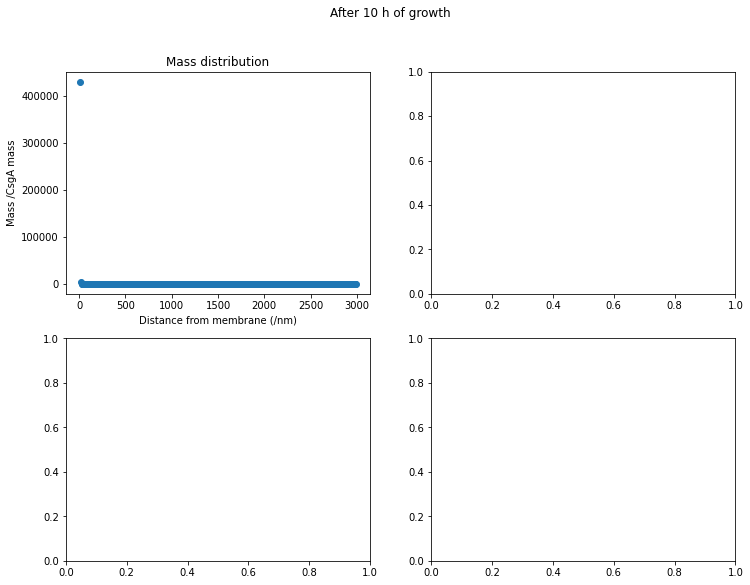

In [23]:
import time 
import matplotlib.pyplot as plt

time0 = time.time()
time1 = time.time()
timesteps = int(43000)
dist = 5e-6
xst = 500
print(f'Xdist {dist/xst}')
diffusion = UniformFibrilFormation(dist, xst, 6*3600/timesteps, cBacteria=1e9)

mass = []
timel = []
for i in range(timesteps):
    if i % (timesteps // 10) == 0:
        print("{prc}% completed in {t}s. Delta T = {dt}".format(prc = str(i / timesteps *100), t = str(time.time() - time0), dt = str(time.time() - time1)))
        print(f'Total mass: {diffusion.totalMass}')
        time1 = time.time()
    diffusion.timeStep()
    mass.append(diffusion.getMass())
    timel.append(diffusion.getTime())

fibrils = []
for i in diffusion.endpointSets:
    fibrils += i.items

xstag = np.linspace(0., dist, xst + 1)
x = (xstag[:-1] + diffusion.deltax/2) / 1e-9
mu = chr(956)
x, diffusion.massProfile = x[:-200], diffusion.massProfile[:-200]
fig, axs = plt.subplots(2,2, figsize=(12,9))
fig.suptitle("After 10 h of growth")
axs[0,0].scatter(x, diffusion.massProfile)
axs[0,0].set_title('Mass distribution')
axs[0,0].set_xlabel('Distance from membrane (/nm)')
axs[0,0].set_ylabel('Mass /CsgA mass')
axs[0,1].plot(x, diffusion.C.U[:-200,0] / 1e-6) #Ändra så den funkar.
axs[0,1].set_title('Monomer concentration')
axs[0,1].set_ylabel(f"Concentration /{mu}M")
axs[0,1].set_yscale('log')
axs[1,0].hist(list(map(lambda i : i.pos*1e9, fibrils)))
axs[1,0].set_title('Endpoint distrubution')
axs[1,0].set_yscale("log")
axs[1,0].set_xlabel('Distance from membrane /nm')
axs[1,1].hist(list(map(lambda i : i.size, fibrils)))
axs[1,1].set_title('Size distribution')
axs[1,1].set_yscale("log")
axs[1,1].set_xlabel('Fibril size /CsgA masses')

curliutil.checkMakeDir('../figures/')
plt.savefig("../figures/Curli_After_10h_spherical.png")


